In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm

Load Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


List all categories in the dataset

In [ ]:
dataset_path = '/content/drive/MyDrive/animal_dataset/animal_dataset'
categories = [c for c in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path,c))]
print("Categories found:", categories)



Categories found: ['panda', 'cat', 'dog']


Load, convert to grayscale, resize, and flatten images

In [ ]:
IMG_SIZE = 32  # resize to 32x32
process_data = []

for idx, cat in enumerate(categories):
    folder = os.path.join(dataset_path, cat)
    for img_name in tqdm(os.listdir(folder), desc=f"Loading {cat}"):
        img_path = os.path.join(folder, img_name)
        img_array = cv2.imread(img_path)
        if img_array is None:
            continue
        gray = cv2.cvtColor(img_array, cv2.COLOR_BGR2GRAY)
        resized = cv2.resize(gray, (IMG_SIZE, IMG_SIZE))
        process_data.append([resized.flatten(), idx])

print("Total images loaded:", len(process_data))


Loading dog: 100%|██████████| 100/100 [00:02<00:00, 40.77it/s]

Total images loaded: 300


Visualizing a Sample of Preprocessed Images with Their Labels

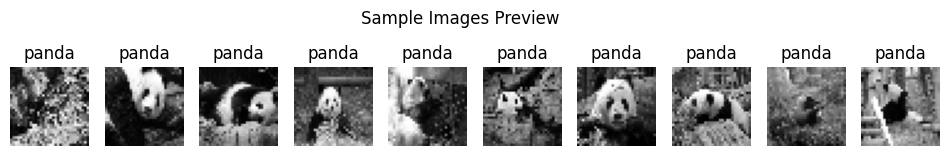

In [ ]:
plt.figure(figsize=(12,2))
for i in range(min(10,len(process_data))):
    img_flat, label = process_data[i]
    plt.subplot(1,10,i+1)
    plt.imshow(img_flat.reshape(IMG_SIZE,IMG_SIZE), cmap='gray')
    plt.title(categories[label])
    plt.axis('off')
plt.suptitle("Sample Images Preview")
plt.show()


Visualizing 30 Random Sample Images After Shuffling

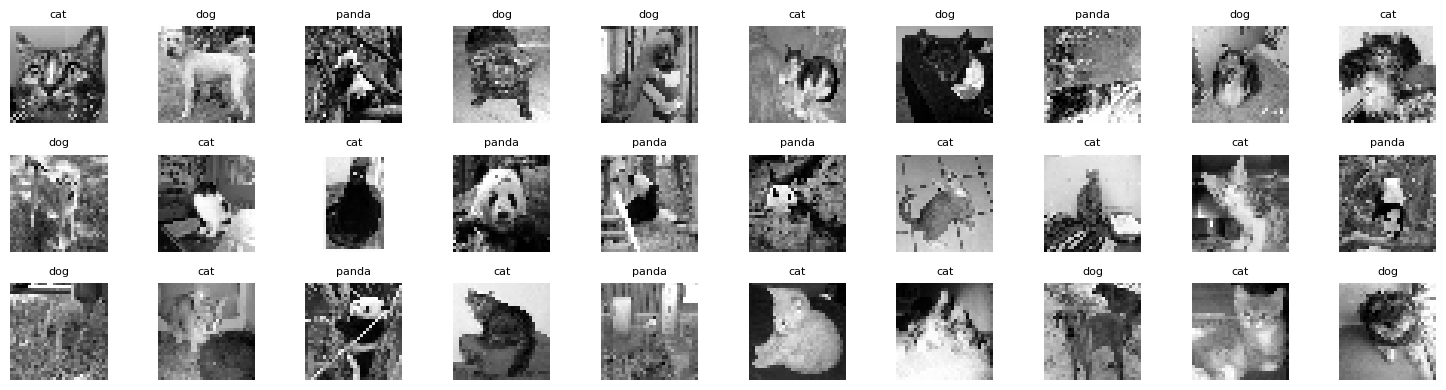

In [ ]:

random.shuffle(process_data)


plt.figure(figsize=(15, 4))

for i in range(30):
    plt.subplot(3, 10, i + 1)
    plt.imshow(process_data[i][0].reshape(IMG_SIZE, IMG_SIZE), cmap='gray')
    plt.title(categories[process_data[i][1]], fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.show()

Shuffle the dataset


In [ ]:
import random

random.seed(42)  # Fix seed for reproducibility
random.shuffle(process_data)

In [ ]:
# fold size
fold_size = len(process_data) // 5

# Create 5 folds
f1 = process_data[0:60]
f2 = process_data[60:120]
f3 = process_data[120:180]
f4 = process_data[180:240]
f5 = process_data[240:300]

folds = [f1, f2, f3, f4, f5]

print("Fold sizes:", [len(f) for f in folds])


Fold sizes: [60, 60, 60, 60, 60]


Define L1 and L2 distance functions

In [ ]:
import numpy as np

def calc_l2_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2)**2))

def calc_l1_distance(x1, x2):
    return np.sum(np.abs(x1 - x2))


Compute L1 distance between two vectors

In [ ]:
def calc_l1_distance(x1, x2):
    return np.sum(np.abs(x1 - x2))

Function to predict the label of a test sample using KNN with L1 or L2 distance

In [ ]:
def knn_predict(X_train, y_train, x_test, k=3, metric='L2'):
    distances = []
    for i in range(len(X_train)):
        if metric=='L1':
            dist = calc_l1_distance(X_train[i], x_test)
        else:
            dist = calc_l2_distance(X_train[i], x_test)
        distances.append((dist, y_train[i]))
    distances.sort(key=lambda x: x[0])
    top_k_labels = [label for _, label in distances[:k]]

    # Majority vote
    vote_count = {}
    for label in top_k_labels:
        vote_count[label] = vote_count.get(label, 0) + 1
    return max(vote_count, key=vote_count.get)


KNN cross-validation for different K values and distance metrics

In [ ]:
K_values = list(range(1,11))
metrics = ['L2','L1']
cv_results = {m:[[] for _ in range(5)] for m in metrics}

for metric in metrics:
    print(f"\n=== Metric: {metric} ===")
    for fold_idx in range(5):
        print(f"\nFold {fold_idx+1}")
        val = folds[fold_idx]
        train = [item for i,f in enumerate(folds) if i!=fold_idx for item in f]

        X_train = np.array([img for img,label in train])
        y_train = np.array([label for img,label in train])
        X_val = np.array([img for img,label in val])
        y_val = np.array([label for img,label in val])

        for K in K_values:
            correct = 0
            for i in range(len(X_val)):
                pred = knn_predict(X_train, y_train, X_val[i], k=K, metric=metric)
                if pred==y_val[i]:
                    correct+=1
            acc = correct/len(X_val)*100
            cv_results[metric][fold_idx].append(acc)
            print(f"K={K}: Accuracy={acc:.2f}%")



=== Metric: L2 ===

Fold 1
K=1: Accuracy=43.33%
K=2: Accuracy=43.33%
K=3: Accuracy=45.00%
K=4: Accuracy=48.33%
K=5: Accuracy=41.67%
K=6: Accuracy=43.33%
K=7: Accuracy=40.00%
K=8: Accuracy=40.00%
K=9: Accuracy=43.33%
K=10: Accuracy=46.67%

Fold 2
K=1: Accuracy=38.33%
K=2: Accuracy=38.33%
K=3: Accuracy=28.33%
K=4: Accuracy=38.33%
K=5: Accuracy=35.00%
K=6: Accuracy=40.00%
K=7: Accuracy=36.67%
K=8: Accuracy=35.00%
K=9: Accuracy=36.67%
K=10: Accuracy=43.33%

Fold 3
K=1: Accuracy=36.67%
K=2: Accuracy=36.67%
K=3: Accuracy=36.67%
K=4: Accuracy=40.00%
K=5: Accuracy=45.00%
K=6: Accuracy=43.33%
K=7: Accuracy=43.33%
K=8: Accuracy=45.00%
K=9: Accuracy=50.00%
K=10: Accuracy=50.00%

Fold 4
K=1: Accuracy=31.67%
K=2: Accuracy=31.67%
K=3: Accuracy=25.00%
K=4: Accuracy=36.67%
K=5: Accuracy=33.33%
K=6: Accuracy=33.33%
K=7: Accuracy=33.33%
K=8: Accuracy=33.33%
K=9: Accuracy=36.67%
K=10: Accuracy=36.67%

Fold 5
K=1: Accuracy=35.00%
K=2: Accuracy=35.00%
K=3: Accuracy=31.67%
K=4: Accuracy=33.33%
K=5: Accurac

Visualize 5-Fold KNN Accuracy Across Different K Values for L1 and L2 Metrics

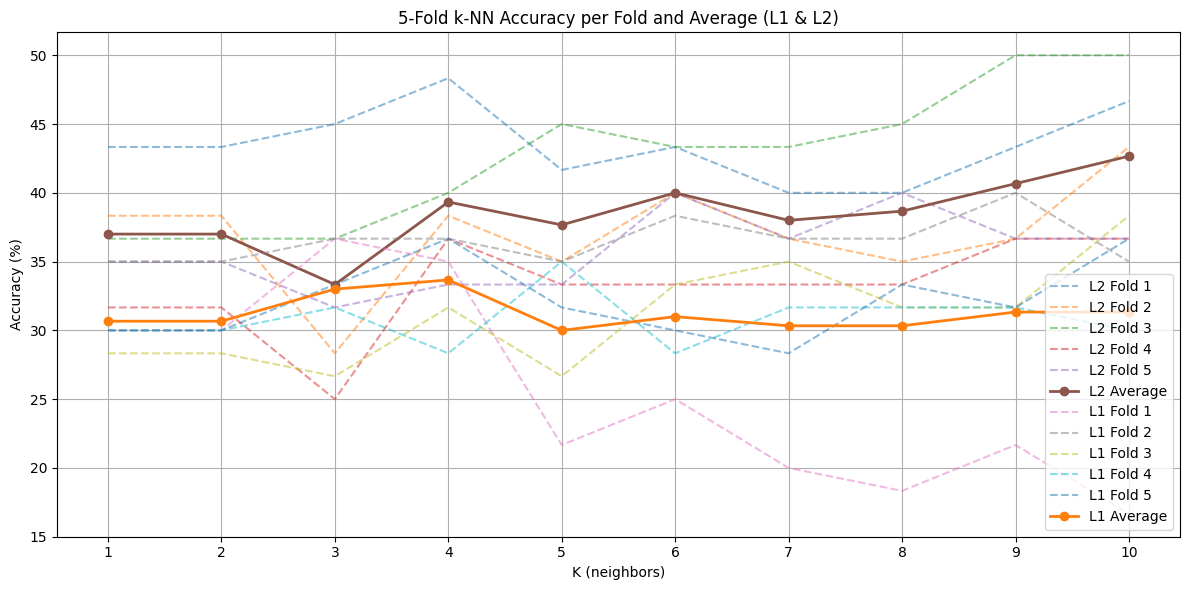

In [ ]:
plt.figure(figsize=(12,6))

for metric in metrics:
    # Fold-wise
    for i in range(5):
        plt.plot(K_values, cv_results[metric][i],'--',alpha=0.5,label=f'{metric} Fold {i+1}')
    # Average
    avg_acc = np.mean(cv_results[metric], axis=0)
    plt.plot(K_values, avg_acc, marker='o', label=f'{metric} Average', linewidth=2)

plt.xlabel('K (neighbors)')
plt.ylabel('Accuracy (%)')
plt.title('5-Fold k-NN Accuracy per Fold and Average (L1 & L2)')
plt.xticks(K_values)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Test KNN predictions on 5 random images and visualize results

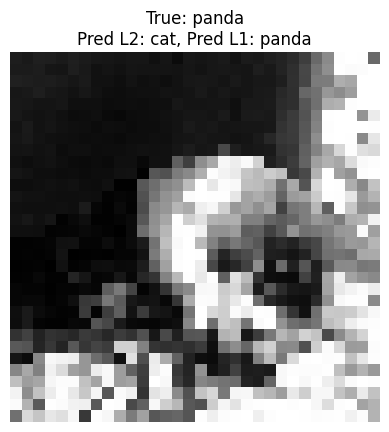

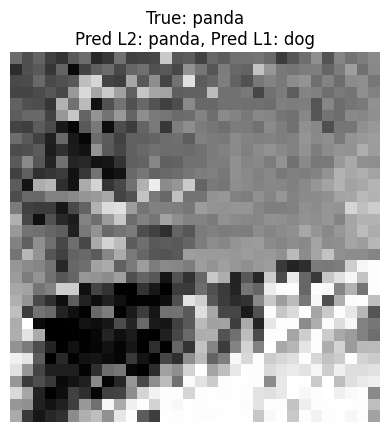

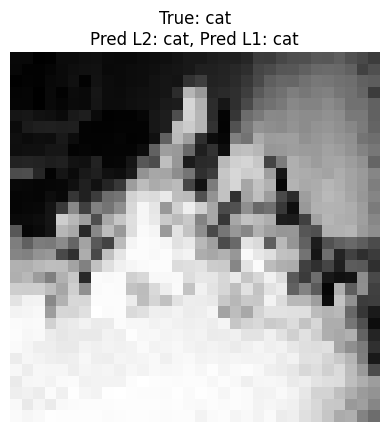

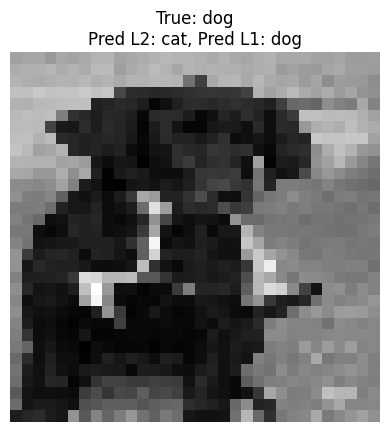

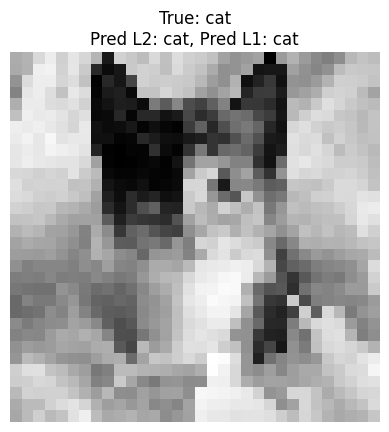

In [ ]:
test_indices = np.random.choice(len(X_train), 5, replace=False)
X_test = X_train[test_indices]
y_test = y_train[test_indices]

for i in range(5):
    pred_l2 = knn_predict(X_train, y_train, X_test[i], k=5, metric='L2')
    pred_l1 = knn_predict(X_train, y_train, X_test[i], k=5, metric='L1')

    plt.imshow(X_test[i].reshape(IMG_SIZE,IMG_SIZE), cmap='gray')
    plt.title(f"True: {categories[y_test[i]]}\nPred L2: {categories[pred_l2]}, Pred L1: {categories[pred_l1]}")
    plt.axis('off')
    plt.show()